In [14]:
id = 42

In [15]:
from werkzeug.wrappers import Request, Response
from jinja2 import Template
from datetime import datetime, timedelta
import collections
from datetime import datetime

from amigocloud import AmigoCloud

In [16]:
acceso = open('../api_key/api.key','r')
api_token = acceso.readlines()[0]
acceso.close()

amigocloud = AmigoCloud(token=api_token)
amigocloud

In [17]:
# DATOS DE LAS INPECCION
query = {'query': 'select CURRENT_DATE, * from dataset_292618 where id = {id}'.format(id=id)}
project = 'https://app.amigocloud.com/api/v1/projects/31874/sql'
select = amigocloud.get(project, query)
data = select['data'][0]
data['date'] = datetime.strptime(data['date'][0:10], '%Y-%m-%d').strftime('%d/%m/%Y')
data['fecha_quema'] = datetime.strptime(data['fecha_quema'][0:10], '%Y-%m-%d').strftime('%d/%m/%Y')
data['fecha_inspeccion'] = datetime.strptime(data['fecha_inspeccion'][0:10], '%Y-%m-%d').strftime('%d/%m/%Y')

insp = collections.namedtuple("insp", data.keys())(*data.values())
print('end')

end


In [18]:
insp

insp(date='30/08/2022', fecha_registro='2022-08-30 18:18:57+00:00', amigo_id='1b0a57dbb4494bc7bce1b83012ae4fda', fecha_quema='28/08/2022', fecha_inspeccion='30/08/2022', fecha_update='2022-08-30 18:55:06.204910+00:00', canhero='7820 / LUISAGA ORTIZ ERWIN', superficie_total=1.94, rendimiento=55.0, produccion=106.7, responsable='Rogelio Acuña Rodríguez', inicio_incendio='Fuera de la propiedad', causa='Origen desconocido', responsable_de_quema='DESCONOCIDO', observaciones=None, link_informe=None, link_informe_editable=None, cite=491, link_comprobante=None, id=42)

In [19]:
# DATOS DE LA PROPIEDAD
query = {'query': 'select * from dataset_293179 where insp_ref_prop = \'{insp_ref_prop}\''.format(insp_ref_prop=insp.amigo_id)}
project = 'https://app.amigocloud.com/api/v1/projects/31874/sql'
select = amigocloud.get(project, query)
propiedades_data = select['data']
print('end')

end


In [20]:
propiedades_data

[{'ubicacion': '0101000020E61000005482AFE4CB8C4FC088EF1CC2C91F31C0',
  'amigo_id': '9977001ba01b4823b3314dce342a4253',
  'fecha_registro': '2022-08-30 18:19:31+00:00',
  'fecha_update': '2022-08-30 18:19:31+00:00',
  'propiedad': '902 / P-001002003--BARBOZA COOPAGRICDE PGUALBERTO VILLARROEL',
  'tenencia': 'Propio',
  'insp_ref_prop': '1b0a57dbb4494bc7bce1b83012ae4fda'}]

In [21]:
propiedades = []
for prop in propiedades_data:
    prop['lote'] = []
    query_lotes = {'query': 'select * from dataset_293180 where prop_ref_lote = \'{prop_ref_lote}\''.format(prop_ref_lote=prop['amigo_id'])}
    project = 'https://app.amigocloud.com/api/v1/projects/31874/sql'
    lotes_select = amigocloud.get(project, query_lotes)
    for lote_select in lotes_select['data']:
        lote = collections.namedtuple("lote", lote_select.keys())(*lote_select.values())
        prop['lote'].append(lote)
    propiedades.append(collections.namedtuple("propiedad", prop.keys())(*prop.values()))
print('end')

end


In [22]:
propiedades

[propiedad(ubicacion='0101000020E61000005482AFE4CB8C4FC088EF1CC2C91F31C0', amigo_id='9977001ba01b4823b3314dce342a4253', fecha_registro='2022-08-30 18:19:31+00:00', fecha_update='2022-08-30 18:19:31+00:00', propiedad='902 / P-001002003--BARBOZA COOPAGRICDE PGUALBERTO VILLARROEL', tenencia='Propio', insp_ref_prop='1b0a57dbb4494bc7bce1b83012ae4fda', lote=[lote(geometria='0106000020E610000001000000010300000001000000060000007939EDFBDE8C4FC004CC0615991F31C0AA0E5CE6C38C4FC0F94B85298A1F31C07CE3CE80C28C4FC0BF6B08F68A1F31C049DE339BB08C4FC0748FB1E7022031C0B8F7EDD8CC8C4FC060FA36020B2031C07939EDFBDE8C4FC004CC0615991F31C0', amigo_id='efacb37a9f1b4835af7265edc3e5932e', fecha_registro='2022-08-30 18:22:55+00:00', fecha_update='2022-08-30 18:24:17.868347+00:00', lote='L4', superficie=1.94, observaciones=None, prop_ref_lote='9977001ba01b4823b3314dce342a4253')])]

In [23]:
# fotos lotes
fotos = []
for propiedad in propiedades:
    for lote in propiedad.lote:
        print(lote.lote, lote.amigo_id)
        query_fotos = {'query': 'select source_amigo_id, s3_filename from gallery_42303 where source_amigo_id=\'{source_amigo_id}\''.format(source_amigo_id=lote.amigo_id)}
        project = 'https://app.amigocloud.com/api/v1/projects/31874/sql'
        fotos_filename = amigocloud.get(project, query_fotos)
        if fotos_filename['data'] != []:
            dic = {'lote': lote.lote, 'file_name': fotos_filename['data'][0]['s3_filename']}
            fotos.append(dic)

fotos

L4 efacb37a9f1b4835af7265edc3e5932e


[{'lote': 'L4', 'file_name': 'image_2022-08-30_142401985.png'}]

In [24]:
from shapely import wkb
import geopandas
import pandas as pd
import contextily as ctx
import matplotlib.pyplot as plt

def convertir_wkb(wkb_data):
    return wkb.loads(wkb_data, hex=True)[0]

end


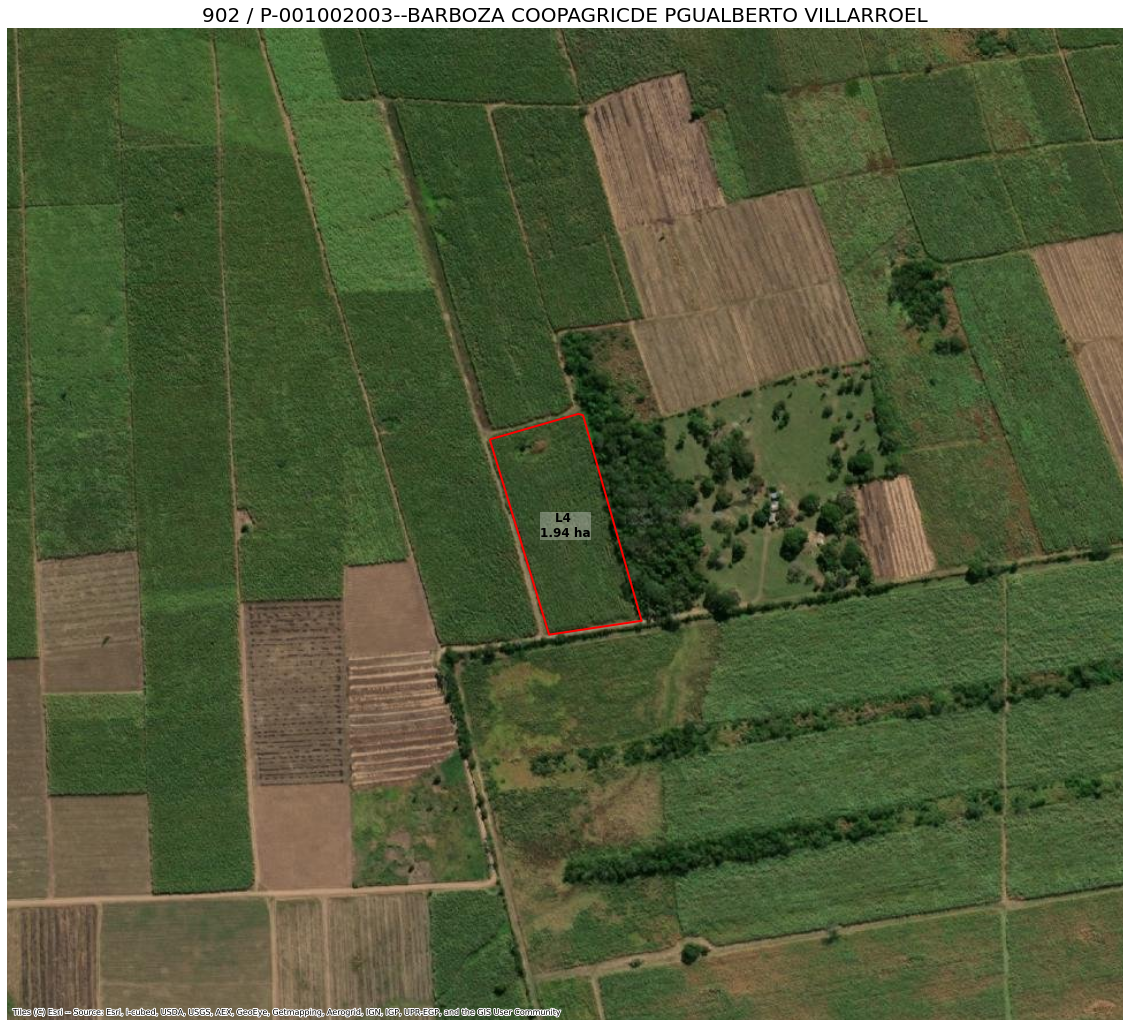

In [25]:
i = 0
lista_planos = []
ruta = ''
for propiedad in propiedades:
    i = i + 1
    lotes_lista = []
    for lote in propiedad.lote:
        lotes_lista.append(lote._asdict())
    df = pd.DataFrame(lotes_lista)
    df['geometria'] = df['geometria'].apply(convertir_wkb)

    #Convertir a GeoDataFrame
    data = geopandas.GeoDataFrame(df, geometry='geometria')
    #data
    #ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

    data['coords'] = data['geometria'].apply(lambda x: x.representative_point().coords[:])
    data['coords'] = [coords[0] for coords in data['coords']]

    data.crs = "EPSG:4326"
    data = data.to_crs(epsg=3857)

    
    fig = plt.figure(i, figsize=(20,20))
    #fig = plt.figure(1)
    ax = None
    ax = fig.add_subplot()

    #data.set_crs(epsg=4326, inplace=True)

    data.apply(lambda x: ax.annotate(text=x.lote + ' \n' + str(x.superficie) + ' ha', xy=x.geometria.centroid.coords[0], ha='center', va='center', color='black', fontsize=12, weight=1000, bbox=dict(facecolor=(1,1,1,0.3), edgecolor='none', pad=0)), axis=1);

    #data.boundary.plot(ax=ax, color=(0,0,0,0), linewidth=0)

    #data = data.to_crs(epsg=3857)

    minx, miny, maxx, maxy = data.total_bounds
    ax.set_xlim(minx - 500, maxx + 500)
    ax.set_ylim(miny - 400, maxy + 400)

    data.plot(ax=ax, edgecolor='r', facecolor=(0,0,0,0), linewidth=2, figsize=(20,20))
    #data.plot(ax=ax, edgecolor='r', facecolor=(0,0,0,0), linewidth=2)
    
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)
    ax.set_axis_off()
    ax.set_title(str(propiedad.propiedad), fontsize=20)
    ruta = 'planos/' + str(insp.amigo_id) + '_' + str(propiedad.amigo_id) + '.jpeg'
    lista_planos.append(ruta)
    fig.savefig(ruta, dpi = 300, bbox_inches='tight')
    del fig
print('end')

In [26]:
from docxtpl import DocxTemplate
import docxtpl
from docx.shared import Mm

import requests

doc = DocxTemplate("templates/template_01.docx")

#generar lista de InlineImage de planos 
lista_InlineImage = []
for plano in lista_planos:
    lista_InlineImage.append(docxtpl.InlineImage(doc, image_descriptor=plano, width=Mm(150)))

#descargar fotos y generar lista InlineImage
lista_fotos_inline = []
for foto in fotos:
    #response = requests.get("https://www-amigocloud.s3.amazonaws.com/gallery/" + foto['file_name'])
    response = requests.get("https://www-amigocloud.s3.amazonaws.com/gallery/" + foto['file_name'])
    file = open('fotos/' + foto['file_name'], "wb")
    file.write(response.content)
    file.close()
    lista_fotos_inline.append({'foto': docxtpl.InlineImage(doc, image_descriptor='fotos/' + foto['file_name'], width=Mm(120)), 'lote': foto['lote']})

firma_respon = None
if insp.responsable == 'Rogelio Acuña Rodríguez':
    firma_respon = docxtpl.InlineImage(doc, image_descriptor='templates/firma_rogelio.png', width=Mm(60))
else:
    firma_respon = docxtpl.InlineImage(doc, image_descriptor='templates/firma_jaldin.png', width=Mm(60))

context = {'insp':insp, 'propiedades':propiedades, 'planos':lista_InlineImage, 'fotos':lista_fotos_inline, 'firma':firma_respon}

doc.render(context)

# formato de nombre de archivo: "123_CQ_01-01-2022_NOMBRE"
cod_nom = insp.canhero.split(' / ')
file_name = cod_nom[0] + '_CQ_' + insp.fecha_inspeccion.replace('/','-') + '_' + cod_nom[1]

doc.save('_' + file_name + '.docx')